In [1]:
# ;export CUDA_VISIBLE_DEVICES=2

In [ ]:
using CUDA, Flux
import JLD2
CUDA.device_reset!()
CUDA.device!(2)
Threads.nthreads()

In [1]:
include("../utils/train.jl")

In [23]:
rbm, J, m, hparams, rbmZ = initModel(nv=28*28, nh=500, batch_size=500, lr=1.5, t=10, gpu_usage = true, optType="Adam")
opt = initOptW(hparams, J);

In [24]:
# modelName = "Eigen-500-T1426"
modelName = "CD-500-T1000"
rbm, J, m, hparams, opt = loadModel(modelName, gpu, idx=-1);
x, y = loadData(; hparams, dsName="MNIST01", numbers=collect(0:9), testset=true);
TS = Test(x,y)
dict = loadDict(modelName);

[ Info: /home/javier/Projects/RBM/Results/models/CD-500-T1000
[ Info: Loadding model J_1000.
[ Info: 10000


In [5]:
dev = gpu

gpu (generic function with 5 methods)

In [6]:
PATH = "/home/javier/Projects/RBM/Results/Figs/"

"/home/javier/Projects/RBM/Results/Figs/"

In [19]:
Models = Dict()
for i in 1:5
    # Models["$i"] = load(PATH * "Rdm-500-T100-BW-replica$i/thermoParams.jld")
    Models["$i"] = load(PATH * "CD-500-T1000-5-BW-replica$i-L/thermoParams.jld")
    # Models["$i"] = load(PATH * "PCD-500-replica$i/thermoParams.jld")
end

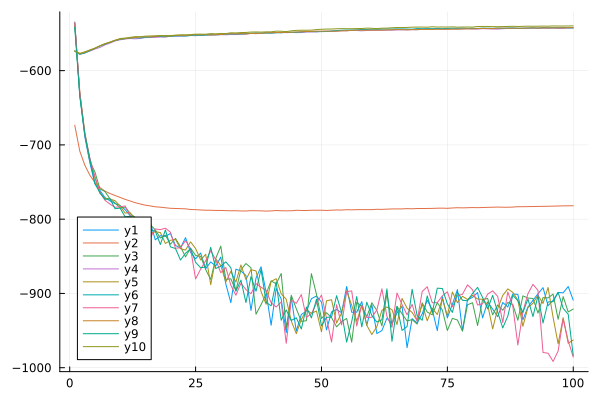

In [20]:
plot()
for i in 1:5
    plot!(Models["$i"]["srbm"])
    plot!(Models["$i"]["sdata"])
end
plot!()

In [2]:
# E0i
include("../therm.jl")

In [3]:
PATH = "/home/javier/Projects/RBM/Results/"
l=100
nv=28*28
nh=500
dev = gpu
β = 1.0
# modelName = "CD-500-T1000-5-BW-replica1-L"
modelName = "PCD-500-replica1"
rbm, J, m, hparams, opt = loadModel(modelName, gpu);
x_i, y_i = loadData(; hparams, dsName="MNIST01", numbers=collect(0:9), testset=true);

[ Info: /home/javier/Projects/RBM/Results/models/PCD-500-replica1
[ Info: Loadding model J_100.
[ Info: 10000


In [4]:
idx=100
J = load("$(PATH)/models/$(modelName)/J/J_$(idx).jld", "J")
J.w = gpu(J.w)
J.b = gpu(J.b)
J.a = gpu(J.a)
F = LinearAlgebra.svd(J.w, full=true);

In [5]:
v,h = data_val_samples(F)
# v,h = gibbs_sampling(v,h,J)
umean, wmean, σ_2u, σ_2w, a0, b0, λ = compute_stats(v, h, J);

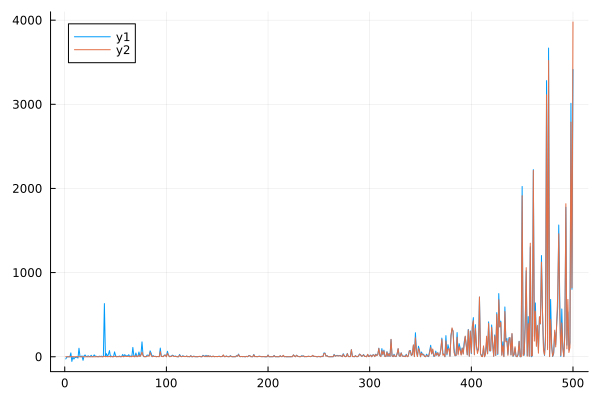

In [77]:
plot(wmean .^ 2 ./ (1 .- σ_2w .* cpu(F.S)))
plot!(umean .^ 2 ./ (1 .+ σ_2u .* cpu(F.S)))
# plot!(σ_2u)

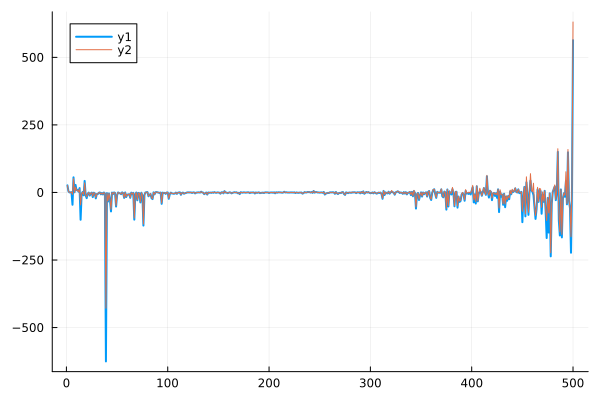

In [86]:
plot(umean .^ 2 ./ (1 .+ σ_2u .* cpu(F.S)) .- wmean .^ 2 ./ (1 .- σ_2w .* cpu(F.S)), lw=2)
plot!(umean .^ 2 ./ (1 .+ σ_2u .* cpu(F.S)) .- wmean .^ 2 ./ (1 .- σ_2w .* cpu(F.S) .+ sign.(1 .- σ_2w .* cpu(F.S)) * 0.02))

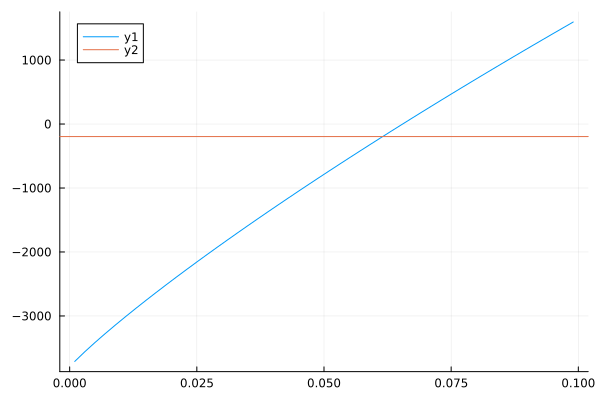

In [100]:
plot(0.001:0.002:0.1, [sum(umean .^ 2 ./ (1 .+ σ_2u .* cpu(F.S)) .- wmean .^ 2 ./ (1 .- σ_2w .* cpu(F.S) .+ sign.(1 .- σ_2w .* cpu(F.S)) * ϵ)) for ϵ in 0.001:0.002:0.1])
hline!([sum((cpu(F.U') * J.a)[1:500] .* cpu(F.Vt) * J.b ./ cpu(F.S))])
# sum(umean .^ 2 ./ (1 .+ σ_2u .* cpu(F.S)) .- wmean .^ 2 ./ (1 .- σ_2w .* cpu(F.S) .+ sign.(1 .- σ_2w .* cpu(F.S)) * 1e-1))

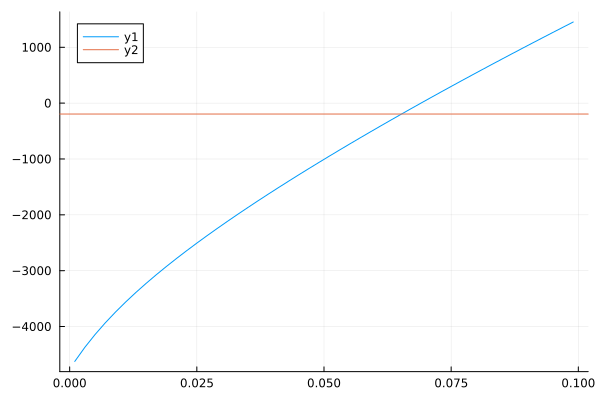

In [102]:
plot(0.001:0.002:0.1, [sum(umean .^ 2 ./ (1 .+ σ_2u .* cpu(F.S)) .- wmean .^ 2 ./ (1 .- σ_2w .* cpu(F.S) .+ sign.(1 .- σ_2w .* cpu(F.S)) * ϵ)) for ϵ in 0.001:0.002:0.1])
hline!([sum((cpu(F.U') * J.a)[1:500] .* cpu(F.Vt) * J.b ./ cpu(F.S))])

In [6]:
function get_samples(v,h,J)
    J.w = cpu(J.w)
    J.b = cpu(J.b)
    J.a = cpu(J.a)
    v = cpu(v)
    h = cpu(h)
    F = LinearAlgebra.svd(J.w, full=true);
    λ = cpu(F.S)
    a0 = cpu(F.U' * J.a)[1:size(λ,1)]
    b0 = cpu(F.Vt * J.b);
    
    l = minimum([size(v,1), size(h,1)])
    x_mean = (F.U' * v)[1:l, :]
    y_mean = (F.Vt * h)
    
    xsp = - cpu(F.Vt * J.b) ./ λ
    ysp = - cpu(F.U' * J.a)[1:l] ./ λ
    umean = 1/√2 .* (cpu(y_mean .+ x_mean) .- ysp .- xsp)
    wmean = 1/√2 .* (cpu(y_mean .- x_mean) .- ysp .+ xsp)
    umean, wmean
end

get_samples (generic function with 1 method)

In [7]:
xxmean, yymean = get_samples(v,h,J)
# umean, wmean, σ_2u, σ_2w, a0, b0, λ = compute_stats(v, h, J);

([2.285518227624506 2.4153888522763984 … 3.5970801058762256 3.210023005289884; -0.347238739015129 0.4605114289612495 … 2.7564258089736953 1.3570264423836944; … ; -3.1069287792591442 -2.94797413173643 … -3.3681084162089094 -2.9094731542091226; -29.86303150121813 -29.540225753900103 … -30.216520154252095 -29.415630228807835], [7.052699203760063 7.206888560002741 … 6.850940554064473 7.038322070796027; -0.9847966031034852 -0.9232222490651916 … -0.6208955711449078 -0.816004038201358; … ; -2.0018690942092188 -1.822048047750943 … -2.029211440712176 -1.8158600474525737; -34.75228441774452 -34.35496034486093 … -35.05947492627666 -34.18546932238527])

In [8]:
# using CairoMakie 
# fig = Figure(; resolution = (700, 700))
# ax1 = Axis(fig, ylabel = "y")
# ax2 = Axis(fig, xlabel = "x", ylabel = "y")
# ax3 = Axis(fig, xlabel = "x", yaxisposition =:right)
# pltobj1 = lines!(ax1, rand(10), rand(10), color = :red)
# pltobj2 = lines!(ax2, rand(10), rand(10))
# pltobt3 = lines!(ax3, rand(10), rand(10), color = :black)
# leg = Legend(fig, [pltobj1, pltobj2, pltobt3],  ["one", "two", "three"], 
#     tellheight = false, tellwidth = false, halign = :left, valign = :top, 
#     framecolor = :orange)
# fig[1,1] = ax1
# fig[2,1] = ax2 
# fig[2,2] = ax3
# fig[1,2] = leg 
# colsize!(fig.layout, 1, Relative(1/2))
# rowsize!(fig.layout, 1, Relative(1/2))
# fig

In [74]:
idx=10
figs_u = []
figs_w = []
for idx in [1,10,100]
    fu = plot(xxmean[idx,:], st=:hist, normalized=true, linewidth=0, frame=:box, xlabel="u", ylabel="PDF", label="EL $idx")
    fu = plot!(umean[idx]-3*√σ_2u[idx]:0.01:umean[idx]+3*√σ_2u[idx], u->1/√(2π*σ_2u[idx])*exp(-(u-umean[idx])^2/(2*σ_2u[idx])), lw=2.5, label="N(uₘ,σ)")
    fw = plot(yymean[idx,:], st=:hist, normalized=true, linewidth=0, frame=:box, xlabel="w", ylabel="PDF", label="EL $idx")
    fw = plot!(wmean[idx]-3*√σ_2w[idx]:0.01:wmean[idx]+3*√σ_2w[idx], w->1/√(2π*σ_2w[idx])*exp(-(w-wmean[idx])^2/(2*σ_2w[idx])), lw=2.5, label="N(wₘ,σ)")
    append!(figs_u, fu)
    append!(figs_w, fw)
end

In [75]:
ff = plot(plot(figs_u[1]), plot(figs_w[1]), plot(figs_u[2]), plot(figs_w[2]), plot(figs_u[3]), plot(figs_w[3]), layout=(3,2), size=(900,700), margin = 5mm)
savefig(ff, "/home/javier/Projects/RBM/Results/Figs/OLD/DistributionsInRecipSpace.png")

"/home/javier/Projects/RBM/Results/Figs/OLD/DistributionsInRecipSpace.png"

In [71]:
figs_u = []
for idx in [1,2,10,100,300,400]
    fu = plot(xxmean[idx,:], yymean[idx,:], s=:auto, markershapes = :circle, lw=0, markerstrokewidth=0, frame=:box, xlabel="u", ylabel="w", label="EL $idx")
    # fu = plot!(umean[idx] .+ randn(1000) .* √σ_2u[idx], wmean[idx] .+ randn(1000) .* √σ_2w[idx], s=:auto, markershapes = :square, lw=0, markerstrokewidth=0, frame=:box, xlabel="u", ylabel="w", label=:none, opacity=0.5)
    
    append!(figs_u, fu)
end

In [73]:
ff = plot(plot(figs_u[1]), plot(figs_u[2]), plot(figs_u[3]), plot(figs_u[4]), plot(figs_u[5]), plot(figs_u[6]), layout=(3,2), size=(1000,700), margin = 5mm)
savefig(ff, "/home/javier/Projects/RBM/Results/Figs/OLD/ScatterPlotsInRecipSpace.png")

"/home/javier/Projects/RBM/Results/Figs/OLD/ScatterPlotsInRecipSpace.png"